Load Data

In [128]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

df.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)

df = df[df['Country/Region'] == 'Singapore']

df_melt = pd.melt(df.iloc[:,1:], var_name='ds', value_name='y')

df_new = df_melt.y

df_new

0          0
1          1
2          3
3          3
4          4
       ...  
315    58230
316    58239
317    58242
318    58255
319    58260
Name: y, Length: 320, dtype: int64

Train-test split

In [129]:
# Split Train-Val into 80-20

test_set = df_new[-round(len(df_new)*0.2):].values

train_set = df_new[:-len(test_set)].values

print(len(train_set), len(test_set))

256 64


Normalise the data

In [130]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(train_set_norm.shape)
print(train_set_norm[:5])

(256, 1)
[[0.00000000e+00]
 [1.73010381e-05]
 [5.19031142e-05]
 [5.19031142e-05]
 [6.92041522e-05]]


Creating Moving Window

In [131]:
import numpy as np

X_train = []
y_train = []

observ = 30 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(226, 30, 1) (226,)


In [132]:
total_test = df_new[-(len(test_set) + observ):].values # use the last 60 days of train to predict 1st day of test

test_set_norm = scaler.fit_transform(total_test.reshape(-1,1))

test_set_norm.shape

(94, 1)

In [133]:
X_test = []
y_test = []

for i in range(observ, len(test_set_norm)):
  X_test.append(test_set_norm[i-observ:i])
  y_test.extend(test_set_norm[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape, y_test.shape)

(64, 30, 1) (64,)


Define Model

In [134]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128)(lstm_input)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('sigmoid')(x)
x = Dense(1)(x)

output = Activation('linear')(x)

model = Model(inputs=lstm_input, outputs=output)

model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_18 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_19 (Activation)   (None, 1)               

In [135]:
model.compile(loss='mse', optimizer='adam')

Train the model

In [136]:
history = model.fit(X_train, y_train,
                    epochs=13,
                    batch_size=72,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/13
4/4 - 1s - loss: 0.3035 - val_loss: 0.2618
Epoch 2/13
4/4 - 0s - loss: 0.0939 - val_loss: 0.0085
Epoch 3/13
4/4 - 0s - loss: 0.0472 - val_loss: 0.0191
Epoch 4/13
4/4 - 0s - loss: 0.0433 - val_loss: 0.0067
Epoch 5/13
4/4 - 0s - loss: 0.0420 - val_loss: 0.0136
Epoch 6/13
4/4 - 0s - loss: 0.0375 - val_loss: 0.0039
Epoch 7/13
4/4 - 0s - loss: 0.0309 - val_loss: 0.0025
Epoch 8/13
4/4 - 0s - loss: 0.0317 - val_loss: 0.0032
Epoch 9/13
4/4 - 0s - loss: 0.0231 - val_loss: 5.9844e-04
Epoch 10/13
4/4 - 0s - loss: 0.0150 - val_loss: 0.0021
Epoch 11/13
4/4 - 0s - loss: 0.0090 - val_loss: 2.7754e-04
Epoch 12/13
4/4 - 0s - loss: 0.0055 - val_loss: 3.2898e-04
Epoch 13/13
4/4 - 0s - loss: 0.0029 - val_loss: 0.0022


Prediction

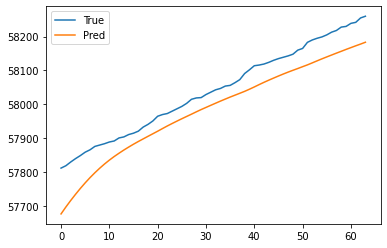

In [137]:
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)

plt.plot(test_set, label = "True")
plt.plot(y_pred, label = "Pred")

plt.legend()
plt.show()

In [138]:
from datetime import datetime
from datetime import timedelta

date = datetime.strptime(df_melt.iloc[-1].ds, '%m/%d/%y') + timedelta(days=1)

# number of cases tomorrow
print("Number of cases on {} is predicted to be {:.0f}".format(date.date(), y_pred[-1][0]))

Number of cases on 2020-12-07 is predicted to be 58183
